<a href="https://colab.research.google.com/github/matiaszabal/End-to-End-Time-Series/blob/master/NVIDIA_02_llm_intake.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><a href="https://www.nvidia.com/en-us/training/"><img src="https://dli-lms.s3.amazonaws.com/assets/general/DLI_Header_White.png" width="400" height="186" /></a></center>

# <font color="#76b900">**2:** LLM Architecture Intuitions</font>

## 2.1. Getting The Model Inputs
As we saw previously, the overall pipeline has to convert to and from the tensor representation using the `preprocess` and `postprocess` functionalities. Looking a little deeper, we can see that the preprocess method relies on the tokenizer, and we can assume that the postprocess does too, so let's look at that pipeline again:

In [5]:
from transformers import BertTokenizer, BertModel, FillMaskPipeline, AutoModelForMaskedLM

class MyMlmPipeline(FillMaskPipeline):
    def __init__(self):
        super().__init__(
            tokenizer = BertTokenizer.from_pretrained('bert-base-uncased'),
            model = AutoModelForMaskedLM.from_pretrained("bert-base-uncased")
        )

    def __call__(self, string, verbose=False):
        ## Verbose argument just there for our convenience
        input_tensors = self.preprocess(string)
        output_tensors = self.forward(input_tensors)
        output = self.postprocess(output_tensors)
        return output

    def preprocess(self, string):
        string = [string] if isinstance(string, str) else string
        inputs = self.tokenizer(string, return_tensors="pt")
        return inputs

    def forward(self, tensor_dict):
        output_tensors = self.model.forward(**tensor_dict)
        return {**output_tensors, **tensor_dict}

    def postprocess(self, tensor_dict):
        ## Very Task-specific; see FillMaskPipeline.postprocess
        return super().postprocess(tensor_dict)


class MyMlmSubPipeline(MyMlmPipeline):
    def __call__(self, string, verbose=False):
        ## Verbose argument just there for our convenience
        input_tensors = self.preprocess(string)
        return input_tensors
        # output_tensors = self.forward(input_tensors)
        # output = self.postprocess(output_tensors)
        # return output


unmasker = MyMlmSubPipeline()
unmasker("Hello, Mr. Bert! How is it [MASK]?", verbose=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


{'input_ids': tensor([[  101,  7592,  1010,  2720,  1012, 14324,   999,  2129,  2003,  2009,
           103,  1029,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}



```
# This is formatted as code
```

In the last notebook, you touched the surface-level interface of the HuggingFace &#x1F917; pipelines and went a single layer deeper, seeing the abstractions associated with the pipeline and looking a little under the hood to how these components might be implemented. Namely, you should now be familiar with the `preprocess -> forward -> postprocess` abstraction which hides the complexity from the user and makes it easy to work with your models. In this notebook, we'll be looking a bit deeper to try and understand what techniques are being used to facilitate this reasoning.

#### **Learning Objectives:**

- Tokenization and embedding intuitions, specifically relating to how the data comes into our models and what properties the network can take advantage of.
- Transformer encoder architectures for performing sequence-level reasoning for an n-sequence-in-n-sequence-out formulation.

In [16]:
%matplotlib inline

**This** shows that the tokenizer is a conversion strategy for converting the input string to a series of tokens. A token is a symbolic representation of something, and is usually reasoned about as a class. Within the scope of language modeling, a token is usually a word, or a letter, or some other substring that can be used as a fundamental building block of a sentence. This is one of the more consistent things among all of the large language models you'll encounter, and also probably one of the conceptually-simplest. Still, it's nice to know what they are and how they operate.

When given our string, the tokenizer responds with several components:
- `input_ids`: These are just the IDs of the tokens that make up our sentence. Said tokens can be words, punctuation, letters, whatever. Just individual entries out of a set vocabulary, exactly like classes.
    - Try the following:
    ```python
    msg = "Hello world and have a great day!"
    unmasker.tokenizer.tokenize(msg)       ## See token boundaries
    # x = unmasker.tokenizer.encode(msg)   ## See special tokens at end
    # x = unmasker.tokenizer.decode(x)     ## See decoding
    # print(x)
    ```

- `token_type_ids`: Added information that the BERT authors realized was useful. This is just an extra flag which tells BERT whether this is the first or the second sentence. This can be useful sometimes (and is a major part of the training objective of BERT specifically), but you'll probably never use it knowingly in practice.
    - Try the following:
    ```python
    unmasker.tokenizer("Hello world!", "Have a great day!")
    ```

- `attention_mask`: To be discussed later; It's a natural input to transformer components and regulates what tokens a specific token can pay attention to. For BERT, this is not necessary, but can be specified.

As far as we will need to be concerned, the `input_ids` are the most important input segment for our model. Considering this, we can intuit how the LLMs approach the task of natural language processing; as reasoning about an **ordered sequence of tokens.** On one hand this should be somewhat reassuring, as classification is a common task in deep learning that you're probably well-familiar with. On the other, you may be a little less familiar with either the process of taking in classes as input or reasoning about sequences. We can go ahead and investigate the model to try to figure out what intuitions the language models might be using to make these problems tractible.

In [17]:
## Feel free to run some code cells here

In [18]:
unmasker.tokenizer("Hello guys, how are you")

{'input_ids': [101, 7592, 4364, 1010, 2129, 2024, 2017, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}

## 2.2. Capturing Token Semantics
A
We now know that natural language reasoning is a problem of inferring insights from an ordered sequence of tokens, so how would we approach that formulation? With regards to classes, we should already have some intuitions:

- **On the output side**, we can output a probability distribution over the set of possible classes. For example, if we were predicting among `cat`, `dog`, and `bird`, we can output a 3-value vector with the intuitive meaning of `<is_cat, is_dog, is_bird>`. For ground-truth, you just use one-hot encodings where the realized instance is 1 and the other options are 0.
- **On the input side**, we could also feed in a one-hot value if we want, but a more efficient strategy when you're primarily dealing with one-hots is to use an **Embedding Layer**, or a glorified matrix where the class index is the row to access. Whichever one you choose, you'll be keeping a record of the semantics associated with the class in your model architecture (either in the weights of the first layer or the weights of the lookup matrix).

With that said, the LLM definitely has a strategy for this:

In [19]:
model = unmasker.model
# dir(model)
# dir(model.bert)
model.bert.embeddings
# model.bert.embeddings.word_embeddings
# model.bert.embeddings.position_embeddings
# model.bert.embeddings.token_type_embeddings

BertEmbeddings(
  (word_embeddings): Embedding(30522, 768, padding_idx=0)
  (position_embeddings): Embedding(512, 768)
  (token_type_embeddings): Embedding(2, 768)
  (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

From this, we can identify the 3 components discussed in the presentation:
- **Word Embeddings:** Semantic vectors representing the input tokens.
- **Position Embeddings**: Semantic vectors representing the position of the words.
- **Token Type Embedding**: Semantic vectors representing whether the token belongs to the first or second sentence.

Notice how the `Embedding` component is constructed with the format:

```
Embedding(in_channel, out_channel)
```

We can see from this that BERT uses 768-dimensional embeddings, and can speculate on how they are obtained. The word embeddings seem to be coming from a 30,522-dimensional vector (the number of unique tokens in the vocabulary), the positional ones from 512, and the token types from just a few. Let's explore these a bit further.

### Investigating the Word Embeddings

Let's go ahead and take a look at the word embeddings:

In [20]:
import torch

tokenizer = unmasker.tokenizer

def get_word_embeddings(string):
    tokens = tokenizer(string)['input_ids']
    tokens = tokens[1:-1] ## Remove cls and sep tokens
    tokens = torch.tensor(tokens)
    return model.bert.embeddings.word_embeddings(tokens)

## Pre-spaced to show where the tokens are. Same results without extra spaces
string = "Hello World From Me, my cat and my dog!"
tokens = [tokenizer.convert_ids_to_tokens(x) for x in tokenizer.encode(string)[1:-1]]
embeddings = get_word_embeddings(string)
print(embeddings.shape)
embeddings

torch.Size([11, 768])


tensor([[-0.0043, -0.0330, -0.0217,  ..., -0.0425, -0.0127, -0.0389],
        [ 0.0244,  0.0322,  0.0024,  ..., -0.0424, -0.0054, -0.0284],
        [-0.0247,  0.0135,  0.0061,  ...,  0.0085,  0.0115,  0.0243],
        ...,
        [ 0.0184,  0.0174, -0.0476,  ..., -0.0721, -0.0358, -0.0127],
        [-0.0149,  0.0124,  0.0091,  ..., -0.0445, -0.0193,  0.0234],
        [ 0.0298, -0.0373, -0.0356,  ...,  0.0161,  0.0192,  0.0173]],
       grad_fn=<EmbeddingBackward0>)

Given what we talked about with embedding vectors, we'd expect the word embedding vectors to capture some of the meanings of the tokens that span our intended natural language. To investigate it, we can go ahead and define some helper functions:

In [26]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

def cosine_similarity(x1, x2):
    """Compute cosine similarity between two vectors."""
    dot_product = x1 @ x2.T
    norm_x1 = torch.norm(x1, dim=-1)
    norm_x2 = torch.norm(x2, dim=-1)
    return dot_product / (norm_x1 * norm_x2)

def scaled_dp_similarity(x1, x2):
    """Compute dot-product similarity between two vectors."""
    dot_product = x1 @ x2.T
    d = torch.sqrt(torch.tensor(x1.shape[-1]))
    return dot_product / d

def softmax_similarity(x1, x2):
    """Compute softmaxed dp similarity between two vectors."""
    out = scaled_dp_similarity(x1, x2)
    return torch.softmax(out, dim=1)


def plot_mtx(matrix, name='', tokens=[]):
    """Compute similarity matrix for embeddings."""
    # Plot similarity matrix
    plt.figure(figsize=(10, 8))
    label_dict = {} if tokens is None else {'xticklabels' : tokens, 'yticklabels': tokens}
    sns.heatmap(
        np.round(matrix.detach().numpy(), 3),
        annot=True, cmap='coolwarm',
        # vmin=-1, vmax=1,
        **label_dict
    )
    plt.title(f"Embedding {name} Matrix")
    plt.yticks(rotation=0)
    plt.show()


With these visualization and metric functions defined, we can view the similarities of the embeddings in different measurement spaces:

- The following will compute the cosine similarity:
  ```python
  plot_mtx(cosine_similarity(embeddings, embeddings), 'Cosine Sim', tokens)
  ```
  You'll notice that we do get some pretty nice properties, and the result is a nice normalized matrix, but unfortunately this throws away distance-related information of the vectors.

- As we'll soon see this idea being incorporated into the architecture, it's worth investigating what happens when we decide to transition to softmax-based similarity:
  ```python
  plot_mtx(softmax_similarity(embeddings, embeddings), 'Softmax(x1) Sim', tokens)
  ```
  You'll see that the matrix is no longer symetric since we're applying softmax on a per-row basis, but it does have a nice intuitive analogue when you format it as a matrix product:
  **Relative to the others, how much does a token contribute to every other token?** This formulation will come up later as "attention."

  You'll also notice that the magnitudes are pretty small, but we can increase the magnitude of the embeddings and observe a much more polarizing similarity matrix.
  ```python
  plot_mtx(softmax_similarity(embeddings*10, embeddings*10), 'Softmax(x10) Sim', tokens)
  ```
  
  Because the metric now factors magnitude into the decision process but keeps the output bounded and under control, this is a great choice when you actually want to inject similarity into optimization (again, foreshadowing).

Regardless, the takehome message for word embeddings is roughly **"learned vector representation for each token based on its meaning and usage in sentences."**

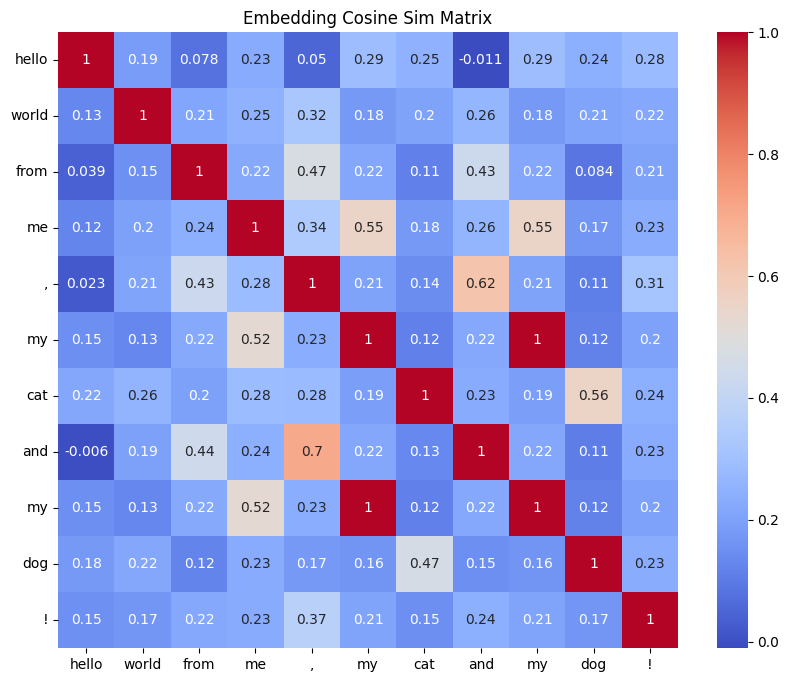

In [29]:
plot_mtx(cosine_similarity(embeddings, embeddings), 'Cosine Sim', tokens)

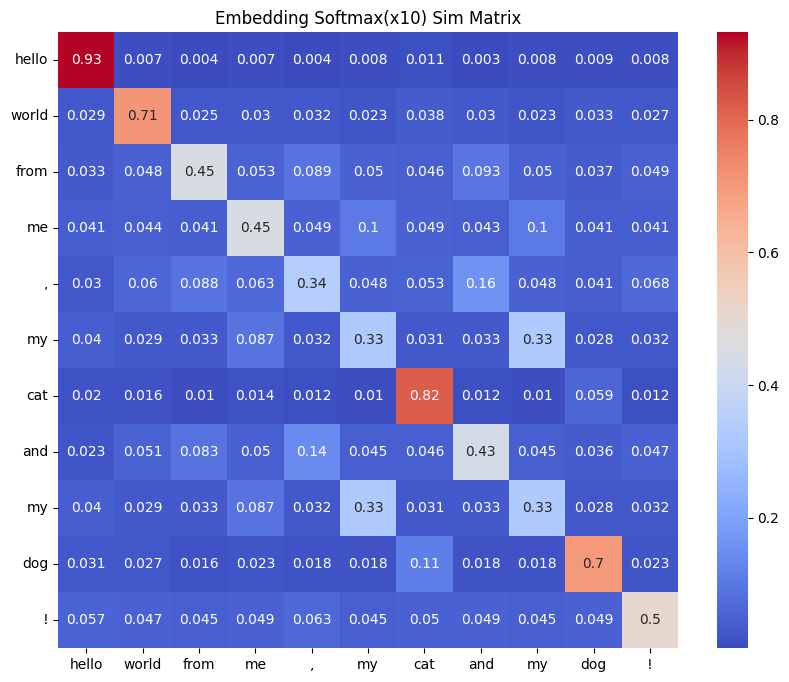

In [30]:
plot_mtx(softmax_similarity(embeddings*10, embeddings*10), 'Softmax(x10) Sim', tokens)

In [22]:
## Please run the code lines and observe what happens

### Investigating the Positional Embeddings

Now that we've seen the word embeddings, we can take a look at the positional embeddings:

```python
model.bert.embeddings.position_embeddings ## -> Embedding(512, 768)
```

In contrast to the word embeddings, there is a new input dimension: 512.

This actually corresponds to the number of input tokens that the BERT model can take in. All modern language models have a limited amount of tokens that can be fed in as a single input entry, and so there are only 512 possible positions to account for for our model.  
- **NOTE:** This limit is actually not a hard limit, and is implemented on a per-model basis due to steep performance degredation. More on this when we talk about attention.

In [31]:
%matplotlib inline
def get_pos_embeddings(string):
    ## NOTE: In the previous method, we removed surrounding tokens for illustration only.
    ## For this one, we will not do the same since the index offset matters.
    tokens = tokenizer(string)['input_ids']
    return model.bert.embeddings.position_embeddings(torch.arange(len(tokens)))

## Pre-spaced to show where the tokens are. Same results without extra spaces
string = "Hello World From Me, my cat and my dog!"
pos_embeddings = get_pos_embeddings(string)
print(pos_embeddings.shape)
pos_embeddings

torch.Size([13, 768])


tensor([[ 1.7505e-02, -2.5631e-02, -3.6642e-02,  ...,  3.3437e-05,
          6.8312e-04,  1.5441e-02],
        [ 7.7580e-03,  2.2613e-03, -1.9444e-02,  ...,  2.8910e-02,
          2.9753e-02, -5.3247e-03],
        [-1.1287e-02, -1.9644e-03, -1.1573e-02,  ...,  1.4908e-02,
          1.8741e-02, -7.3140e-03],
        ...,
        [-9.6208e-03, -2.1375e-03, -1.1794e-02,  ...,  2.4868e-02,
          1.2836e-02,  1.2238e-02],
        [-1.1239e-02,  4.1275e-03, -1.6536e-02,  ...,  1.8726e-02,
          1.4024e-02,  8.7044e-03],
        [-1.5178e-02,  5.2001e-03, -2.7250e-03,  ...,  1.6257e-02,
          1.9132e-04,  9.7079e-03]], grad_fn=<EmbeddingBackward0>)

The main difference you may have noticed is that instead of feeding in the tokens directly into the embedding layers, we're only feeding in a sequence of indices, literally via `torch.arange(n) = torch.tensor([0, 1, ..., n-1])`. The original "Transformers Is All You Need" paper used Positional "Encoding" which are pre-computed by a sinosoidal algorithm, but we can see that BERT just directly optimizes them instead. If it works, it works!

You'll notice that the positional embedding has a more predictable and uniform cosine similarity plots compared to the word embeddings, which are all actually pretty consistent with a few key exceptions.

```python
plot_mtx(cosine_similarity(pos_embeddings, pos_embeddings), 'Cosine Sim', tokens)
```

**You're free to visualize a subset of the positional embeddings matrix below.**

In [33]:
## Please run the code lines and observe what happens

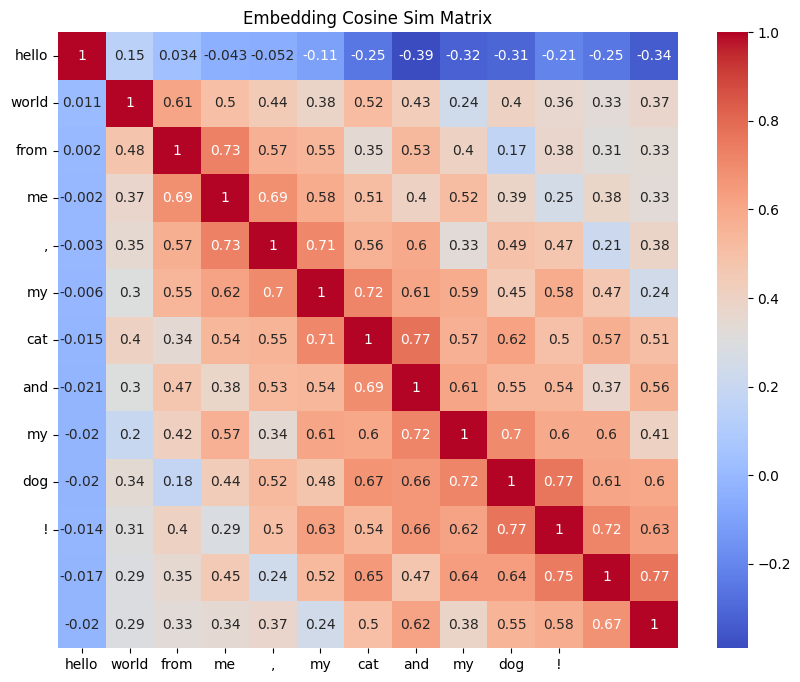

In [28]:
plot_mtx(cosine_similarity(pos_embeddings, pos_embeddings), 'Cosine Sim', tokens)

### The Tail-End of the Embedding

To wrap up our embedding discussions, we do still have our **token_type_embedding** embeddings, but they follow roughly the same logic; just take in some extra semantic information about the sentence structure, and encode it in. The authors saw that this extra bit of information was necessary, so the overall embedding definition for BERT is:

`embed = WordEmbed[token] + PosEmbed[pos] + TypeEmbed[pos]`

In [34]:
model.bert.embeddings

BertEmbeddings(
  (word_embeddings): Embedding(30522, 768, padding_idx=0)
  (position_embeddings): Embedding(512, 768)
  (token_type_embeddings): Embedding(2, 768)
  (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

Then at the end, the LayerNorm section and Dropout section are also included,

1.   List item
2.   List item

and these will permiate your architectures going forward. A light discussion is sufficient to motivate them:

- The [LayerNorm layer](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html) normalizes the data flowing through it so that each minibatch subscribes to a similar distribution. You've probably seen [BatchNorm](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html) from computer vision; this has a similar logic, but now the normalization covers the layer outputs instead of the batch.
    - [Build Better Deep Learning Models with Batch and Layer Normalization | **PineCone.io**](https://www.pinecone.io/learn/batch-layer-normalization/)
    - [**PowerNorm** paper](https://arxiv.org/abs/2003.07845): Contains a deeper analyzes of Batch/Layer Norm and problems for the LLM use-case
- The [Dropout layer](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) just masks out some of the values during training. You've probably seen this before, and the logic is the same as usual; prevent over-reliance on a selection of features and distribute the logic throughout the network.

From here, it is useful to remind you that HuggingFace is an open-source platform! Though it is quite large, its logic becomes transparent when you know where to look. In this case, we can see the code for how all of these things come together in [`transformers/models/bert/modeling_bert.py`](https://github.com/huggingface/transformers/blob/0a365c3e6a0e174302debff4023182838607acf1/src/transformers/models/bert/modeling_bert.py#L180C11-L180C11). Perusing the source code can help answer ambiguities about technical details such as "is this addition or concatenation" (it's addition) or "are there additional steps necessary to make this scheme work in practice" (yes). Please check it out and try to appreciate how litte information is actually necessary for the model to perform its reasoning.

## 2.3. From Token-Level Reasoning to Passage-Level Reasoning

**To summarize the key points of the LLM intake strategy:**

- We take in a passage as an ordered sequence of tokens which we obtain by passing the string through the tokenizer.
- We train up embeddings corresponding to the token features (meanings, positions, etc.), and incorporate them together (in this case, literally by adding them).  

**With this, we have some obvious options for how to reason about our data:**

- We can just take our sequence of tokens, and then reason about each one of those one-at-a-time. This is quite similar to what we did in classification tasks, so we know it does work.
    - **Problem:** This isn't good enough for text passages since the tokens have to reason about the other tokens in the sequence.
- On the other hand, we can try to reason about these things all at once by combining them and passing the data through dense layers
    - **Problem:** This will create a dense neural network that is intractable to optimize.

The LLM solution is to do something between those two options: Allow reasoning to be done on each token, but also allow for small opportunities in which the network can combine the token reasoning and consider the sequence as a whole! That's where the **transformer** components come in!

### Transformer Attention

**Transformers** are deep learning components described in the 2017 paper [*Attention Is All You Need*](https://arxiv.org/abs/1706.03762) for reasoning with language tasks, and the resulting architecture has been making its way into almost every state-of-the-art language modeling architecture since. This architecture uses an ***attention mechanism*** to create an interface where the other entries of the sequence can communicate semantic information to other tokens in the series.

The formulation goes as follows: If we have semantic and positional information present in our embeddings, we can train a mapping from our embeddings into three semantic spaces $K$, $Q$, and $V$:

- `Key` and `Query` are arguments to a similarity function (recall scaled softmax attention) to guage how much weight (or attention) should be given between any pair of sequence entries in the input.
    - In practice, the inputs to a specific transformer block are latent embeddings of the original tokens.
- `Value` is the information that should pass through to the next component, and is weighted by `SoftmaxAttention(Key, Query)` to produce an output that is positionally and semantically motivated.

**In other words:** Given a semantic/position-rich sequence of $d_k$-element embeddings ($S$) and three dense layers ($K$, $Q$, and $V$) that operate per-sequence-entry, we can train a neural network to make semantic/position-driven predictions via the forward pass equation:

$$\text{Self-Attention} = \text{SoftmaxAttention}(K_s, Q_s) \cdot V_s$$$$= \frac{K_s Q_s ^T}{\sqrt{d_k}}V_s$$

<div><img src="imgs/attention-logic.png" width="1000"/></div>

**Key Observations:**

- Since the embeddings have both semantic and positional information, this will be able to reason about both the general meanings and the word order of an input sequence.
- Since scaled softmax attention is being used, the magnitude and cosine similarity of `Key` and `Query` all play a role in the decision-making process while the optimized result remains nicely-bounded.
- Since sequence length dimension gets preserved by matrix multiplication, there is a nice interpretation to the resulting attention matrix: **"What percentage of attention should each token pay to its surrounding tokens"**.

This flavor of attention is called **self-attention**, since all of the `Key`, `Query`, and `Value` vectors are inferred from the same sequence. Other flavors will be presented later as necessary.

### Seeing Attention in the BERT Encoder

Now that we've reviewed the logic of how self-attention works, let's look through the BERT encoder to see how our embeddings are treated:

In [35]:
unmasker.model.bert.encoder

BertEncoder(
  (layer): ModuleList(
    (0-11): 12 x BertLayer(
      (attention): BertAttention(
        (self): BertSdpaSelfAttention(
          (query): Linear(in_features=768, out_features=768, bias=True)
          (key): Linear(in_features=768, out_features=768, bias=True)
          (value): Linear(in_features=768, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (output): BertSelfOutput(
          (dense): Linear(in_features=768, out_features=768, bias=True)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (intermediate): BertIntermediate(
        (dense): Linear(in_features=768, out_features=3072, bias=True)
        (intermediate_act_fn): GELUActivation()
      )
      (output): BertOutput(
        (dense): Linear(in_features=3072, out_features=768, bias=True)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=T

Let's just talk about these components:
- `BertAttention`: This component takes a sequence of vectors (let's call it `x`) as input and gets the `Q`, `K`, and `V` components via `query(x)`, `key(x)`, and `value(x)`, respectively. As these are all $768$-dimensional vectors - and are thereby multiplicatively compatible under transpose - the layer performs the attention computation with a few key modifications:
    - **Multi-Headed Attention:** This is talked about in lecture, but essentially $K$, $Q$, and $V$ are all slices up along the embedding dimension such that we get 12 trios with dimension $768/12 = 64$. This will give us 12 different attention results, and hence will allow the network to distribute attention in a variety of ways. At the end, just concatenate embedding-wise and you'll be back up to 768-features vectors.
    - **Masked Attention:** This is less useful for BERT but explains what the `attention_mask` input is doing. Essentially, it's an boolean "should-I-add-negative-infinity-to-the-attention" mask to keep the model from attending to things it shouldn't. For inference purposes, this is usually not important barring the presence of padding tokens. When using off-the-shelf pipelines for inference, you can ignore attention masks in most cases and can assume that the pipeline will take care of it.
    - **Residual Connections:** To help the network keep the token-level information propagating through the network (and to improve the overall gradient flow), most architectures add residual connections around the transformer components.

- `BertSelfOutput -> BertIntermediate -> BertOutput`: These are all just token-level dense layers with non-linear activations and some `LayerNorm`/`Dropout` layers mixed in for regularization. Each element in the sequence is thereby ran through a MLP with dimension $768 \to 768 \to 3072 \to 768$ to a new representation.

And... there are 12 of these, stacked one after the other! Not too bad, huh?

In [61]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [78]:
cd /content/drive/MyDrive/senda/send


/content/drive/MyDrive/senda/send


In [79]:
!pwd

/content/drive/MyDrive/senda/send


<div><img src="imgs/bert-construction.png" width="800"/></div>

### Visualizing The Attention Mechanism In Action

Recall that there are 12 `SelfAttention` layers and each one has 12 attention heads reasoning about a different properties of the sequence. As such, we can request the realized attention values computed at each `SelfAttention` layer:

In [80]:
import torch

string = "Hello Mr. Bert! How is it [MASK]?"
input_tensors = unmasker.preprocess(string)
embeddings = unmasker.model.bert.embeddings(input_tensors['input_ids'])
x = unmasker.model.bert.encoder(embeddings, input_tensors['attention_mask'], output_attentions=True)
## NOTE, you can also feed it in as an argument on model construction

print('', "From encoder.forward():", sep='\n')
for k,v in x.items():
    if type(v) in (tuple, list):
        print(f" > '{k}' : {torch.stack(v).shape}")
    else:
        print(f" > '{k}' : {v.shape}")


BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.



From encoder.forward():
 > 'last_hidden_state' : torch.Size([1, 12, 768])
 > 'attentions' : torch.Size([12, 1, 12, 12, 12])


In [82]:
!pip install bertviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.6/157.6 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.6/82.6 kB 4.5 MB/s eta 0:00:00


As the transformer architecture largely avoids mixing semantics/position information outside of the attention mechanism. As such, you can claim that the attention localized at any head loosely considers the impact of the whole sequence on a particular sequence entry (aka token).

To visualize this, we can use the [`BertViz` package](https://github.com/jessevig/bertviz) to display the attention associations from our last forward pass in an interactive grid! Please feel free to test this out with other input strings to see what changes.
- See what happens to the dimensionality when you increase the number of tokens.
- See what happens to the connections, and see if you see any patterns worth noting.
- Why do you think the CLS and SEP tokens get so much attention in many of the attention heads?

In [83]:
from bertviz import model_view

import torch
from transformers import pipeline

string = "Hello Mr. Bert! [MASK] should be fun!"
input_ids = unmasker.tokenizer.encode(string)
input_tokens = unmasker.tokenizer.convert_ids_to_tokens(input_ids)

input_tensors = unmasker.preprocess(string)
embeddings = unmasker.model.bert.embeddings(input_tensors['input_ids'])
x = unmasker.model.bert.encoder(embeddings, input_tensors['attention_mask'], output_attentions=True)

model_view(x['attentions'], input_tokens)  # Display model view

<IPython.core.display.Javascript object>

## 2.4. Wrapping Up

At this point, we've shows the core intuitions of how these models reason about text:

- Embed the semantics and positions of the tokens.
- Reason about the token components, mostly in isolation and with small and tight interfaces to consider the other tokens in the sequence.

These several modifications are intuitive to understand and work well in practice, and just about every model we interact with will rely on this intuition.

**In the next section, we'll find out more about how they are used in practice, and will see some of the other things we can do with it!**


In [ ]:
## Please Run When You're Done!
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

<center><a href="https://www.nvidia.com/en-us/training/"><img src="https://dli-lms.s3.amazonaws.com/assets/general/DLI_Header_White.png" width="400" height="186" /></a></center>